In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalHmm import *
from model import model


import matplotlib.pyplot as plt

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
amortizer = AmortizedMixturePosterior(
    amortized_mixture = AmortizedMixture(
        inference_net = DependentClassificator(num_outputs=model.n_cls, bidirectional=False)
    ),
    amortized_posterior = AmortizedPosterior(
        inference_net = bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"),
        summary_net = bf.networks.SequenceNetwork(summary_dim=model.n_par*3, num_conv_layers=4),
        summary_loss_fun = "MMD"
    )  
)

In [4]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, checkpoint_path="checkpoints/filtering_posterior", configurator=lambda x: x)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [5]:
%time
h = trainer.train_online(epochs=100, iterations_per_epoch=1000, batch_size=32)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.72 µs


Training epoch 50: 100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s, Epoch: 50, Iter: 1000,Mix.Loss: 8.604,Post.Loss: 1.016,W.Decay: 0.033,Avg.Mix.Loss: 6.535,Avg.Post.Loss: 0.445,Avg.W.Decay: 0.033,LR: 0.00E+00]


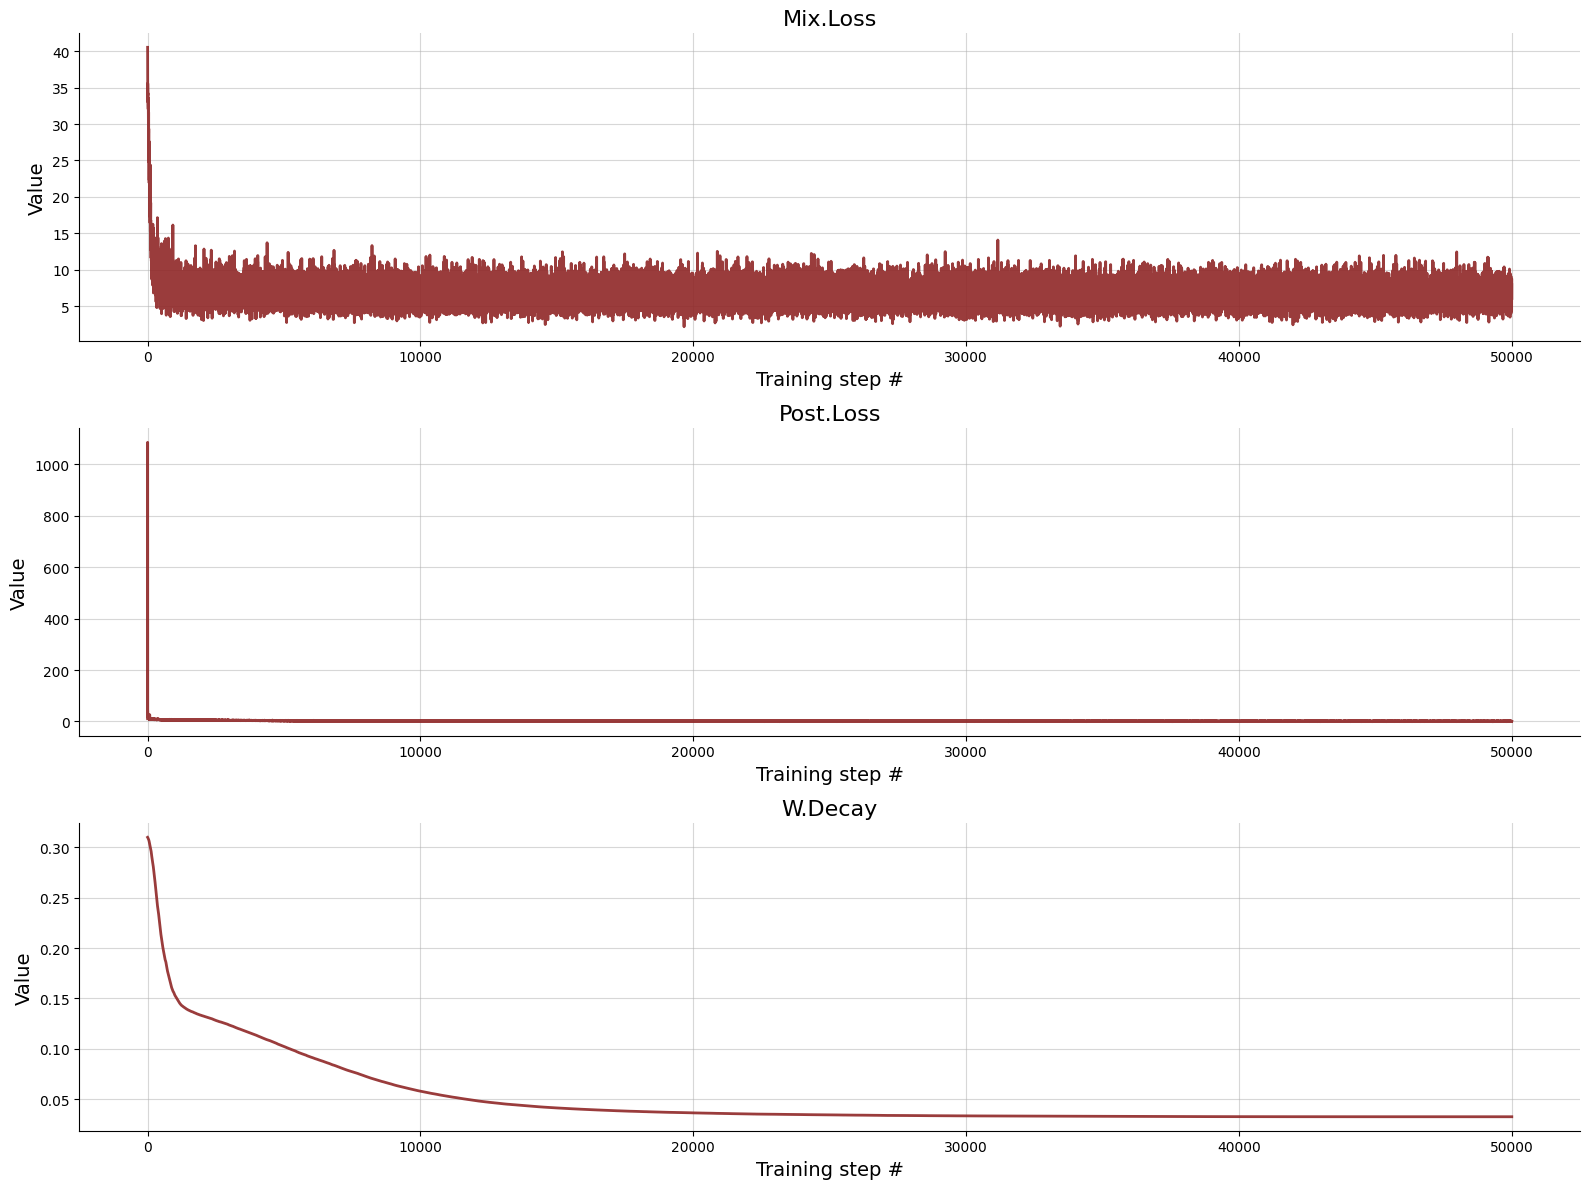

In [6]:
f=bf.diagnostics.plot_losses(h)

In [7]:
df = model(1000, context = {'n_obs': 100})

In [8]:
z, _ = trainer.amortizer.amortized_posterior(df)

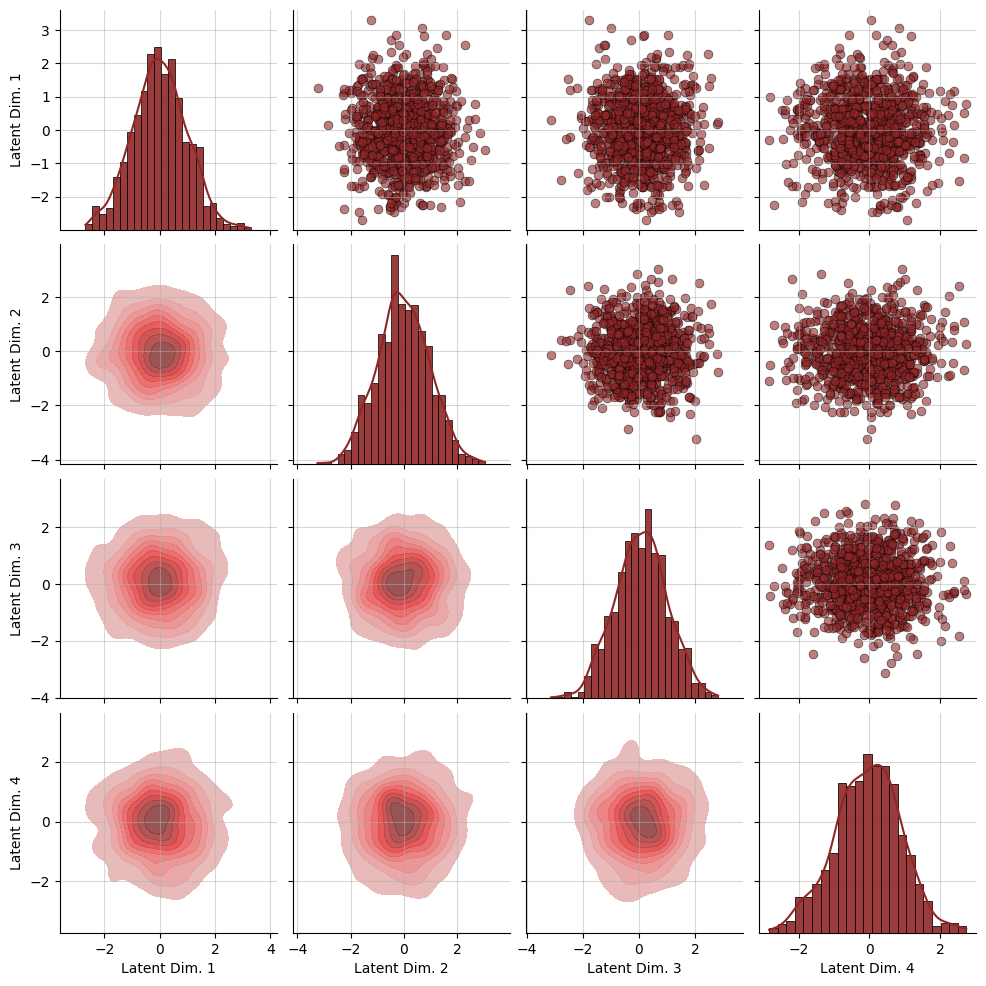

In [9]:
f = bf.diagnostics.plot_latent_space_2d(z)

In [10]:
prior_samples = df['parameters']
posterior_samples = trainer.amortizer.amortized_posterior.sample(df, n_samples=1000)

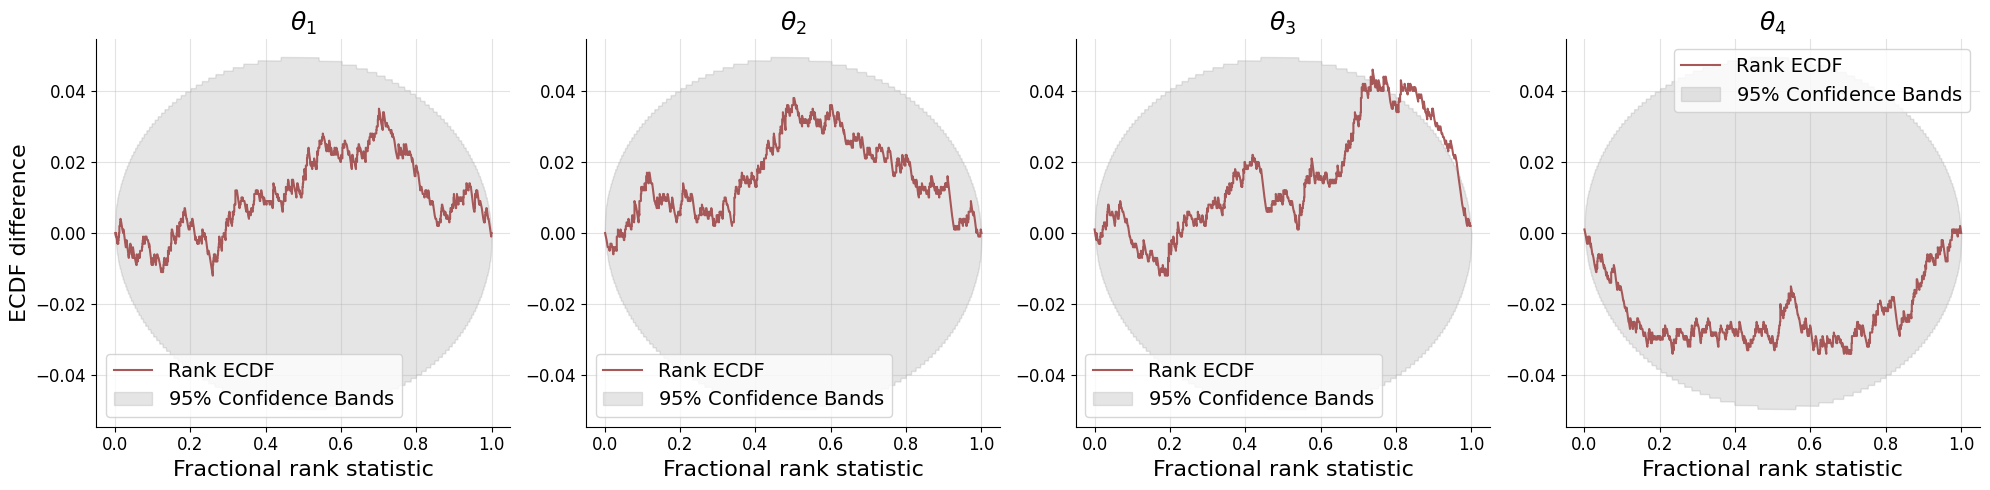

In [11]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples, difference=True)

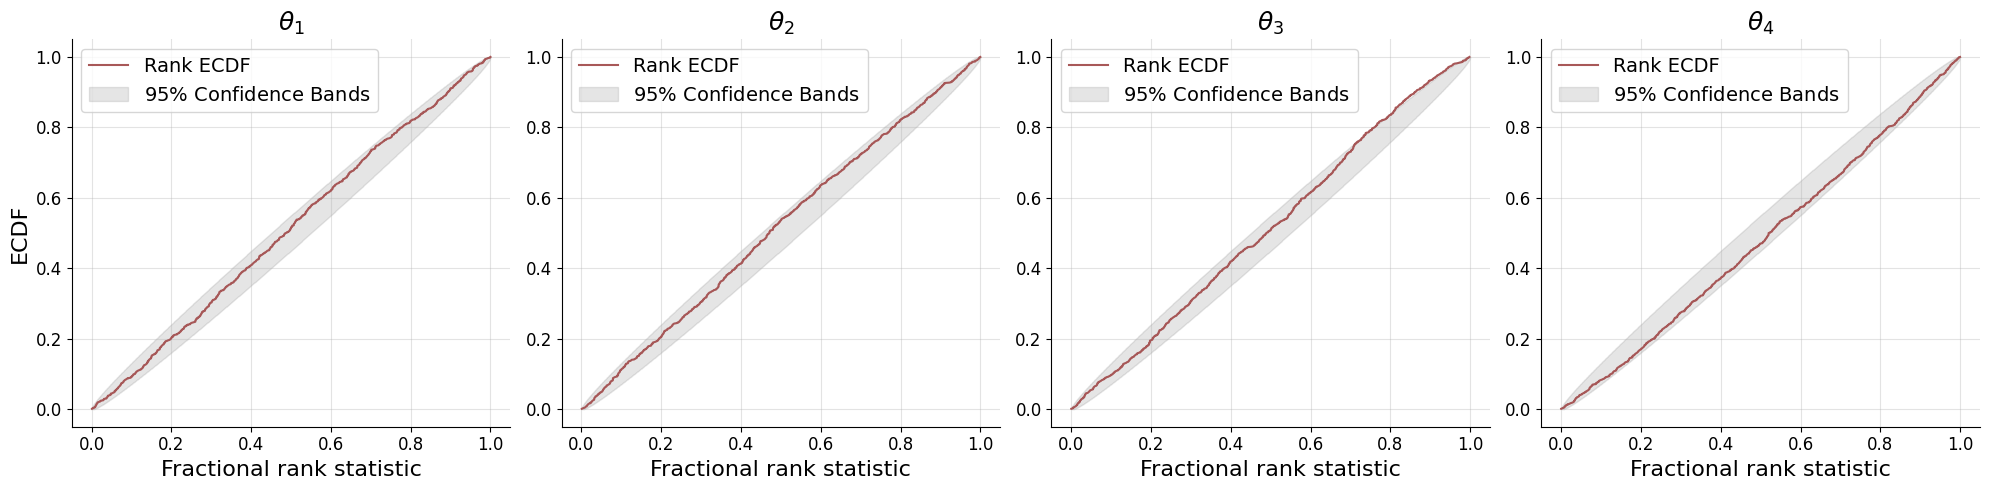

In [12]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_samples)

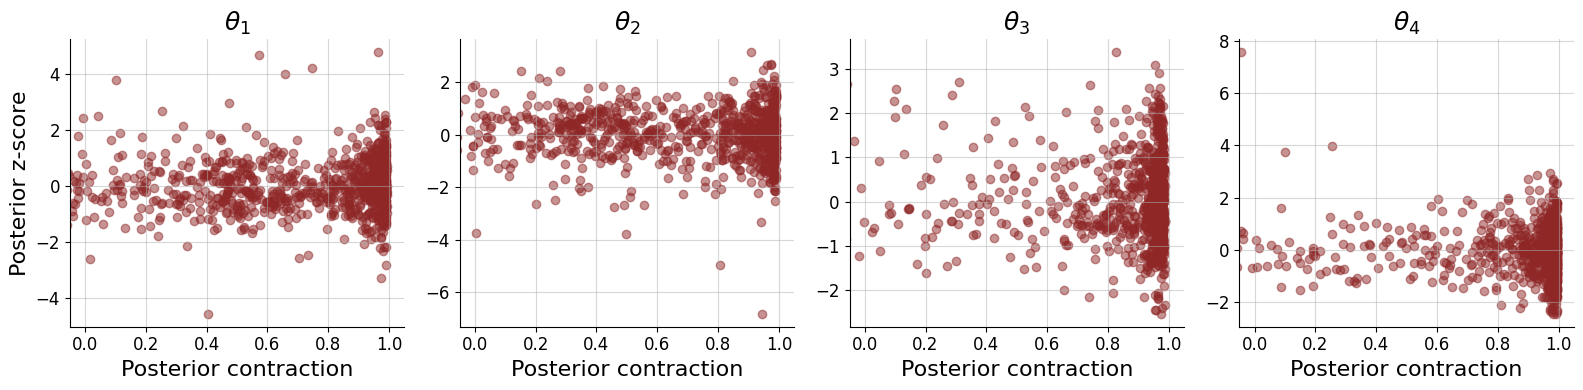

In [13]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_samples)

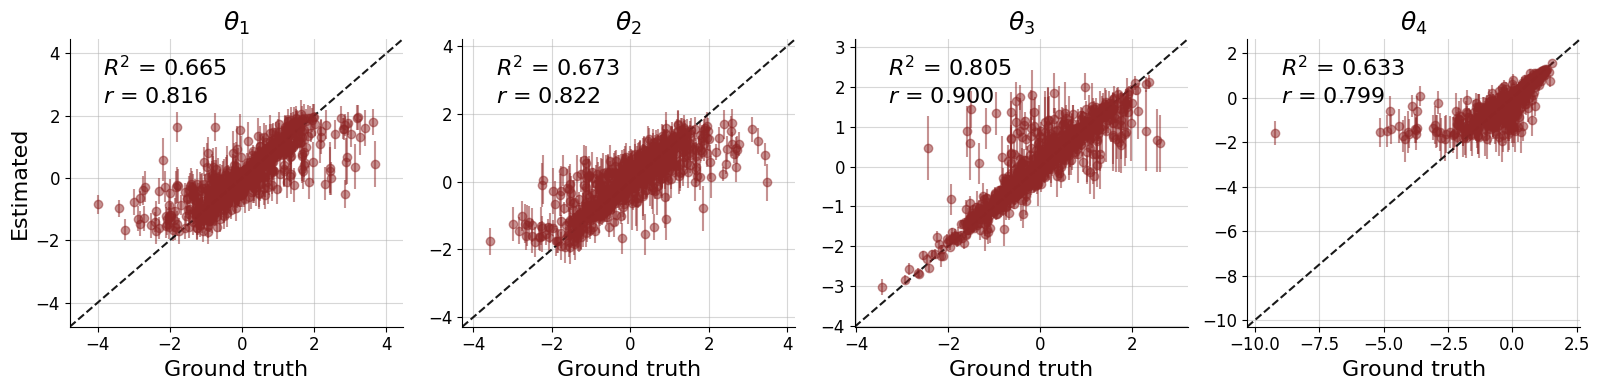

In [14]:
f = bf.diagnostics.plot_recovery(posterior_samples, prior_samples)

## Constrained parameters

In [15]:
prior_p, prior_mu = model.extract_pars(prior_samples).values()

posterior_p, posterior_mu = model.extract_pars(posterior_samples).values()

### Transition matrix

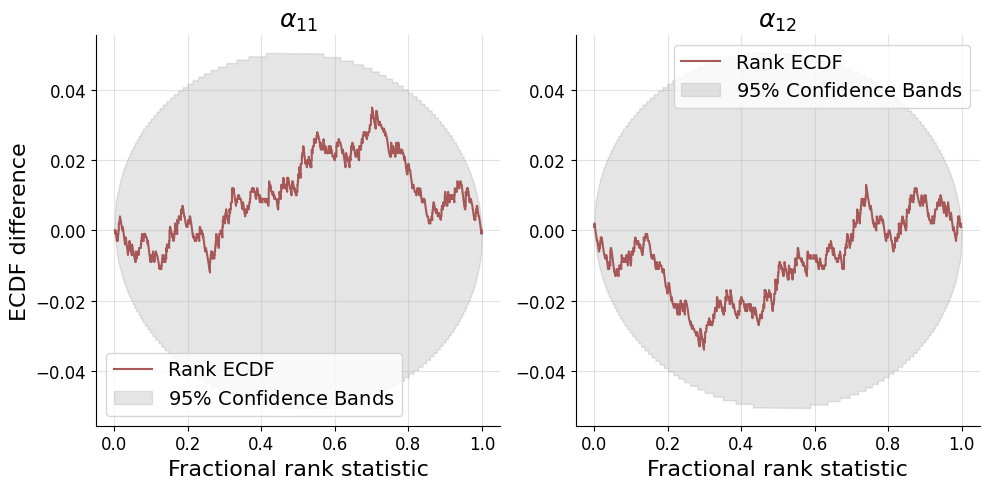

In [16]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_p[:,:,0,:], prior_p[:,0,:], difference=True, param_names=[r'$\alpha_{11}$', r'$\alpha_{12}$'])

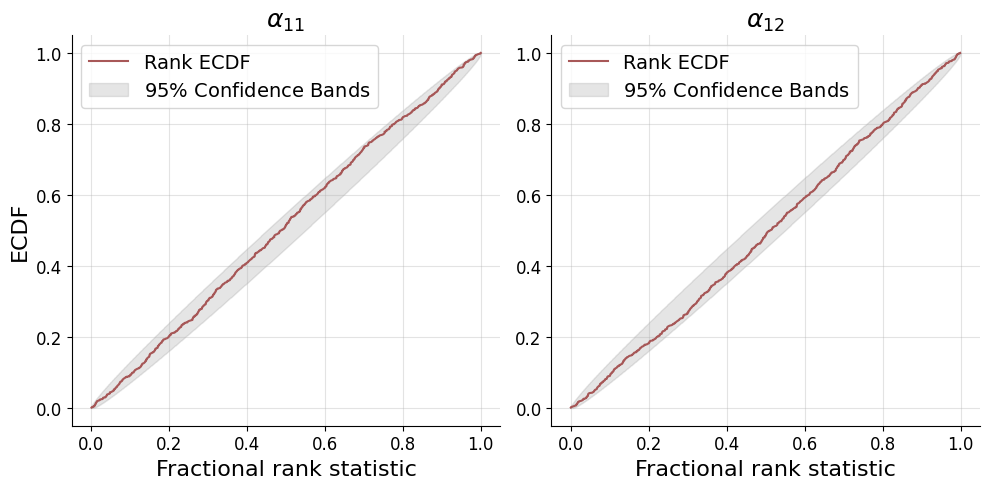

In [17]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_p[:,:,0,:], prior_p[:,0,:], param_names=[r'$\alpha_{11}$', r'$\alpha_{12}$'])

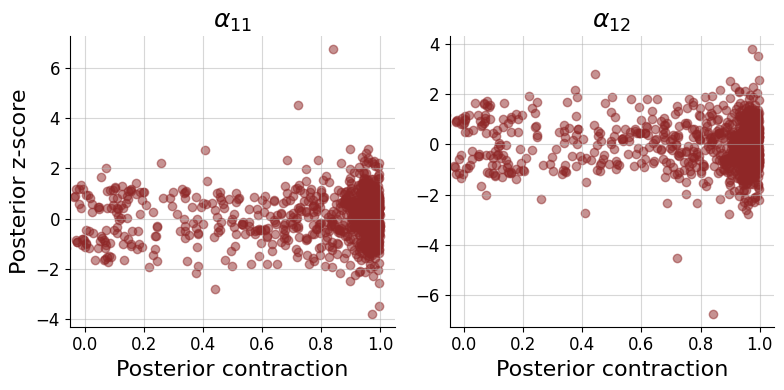

In [19]:
f = bf.diagnostics.plot_z_score_contraction(posterior_p[:,:,0,:], prior_p[:,0,:], param_names=[r'$\alpha_{11}$', r'$\alpha_{12}$'])

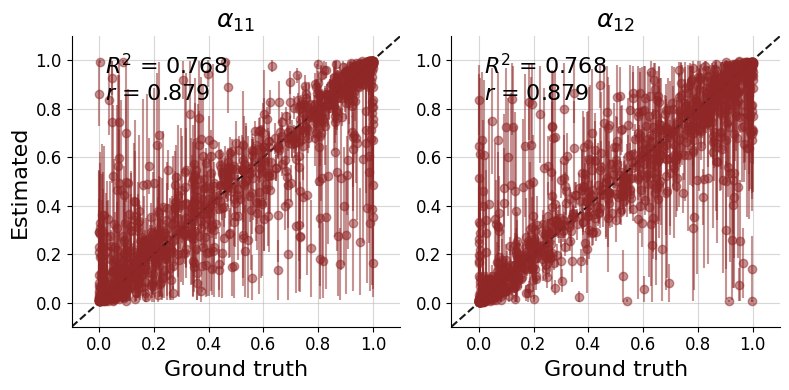

In [20]:
f = bf.diagnostics.plot_recovery(posterior_p[:,:,0,:], prior_p[:,0,:], param_names=[r'$\alpha_{11}$', r'$\alpha_{12}$'])

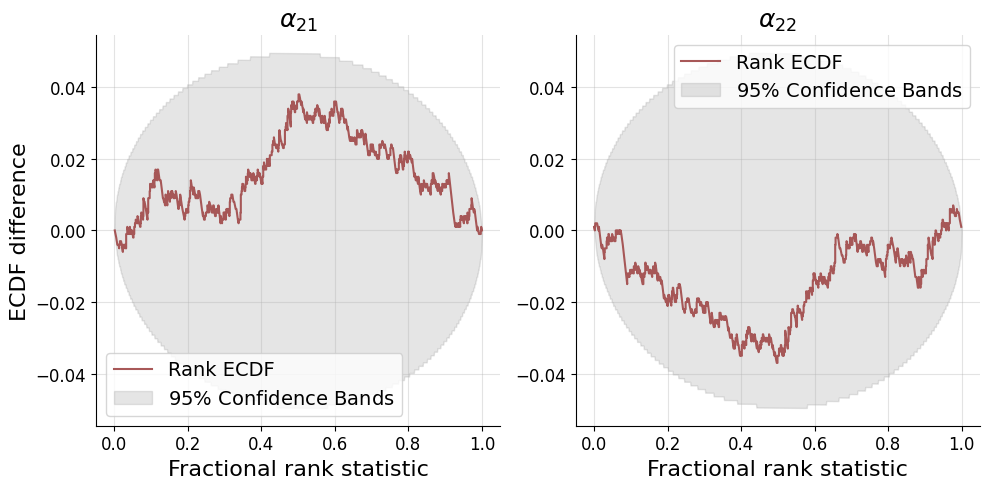

In [21]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_p[:,:,1,:], prior_p[:,1,:], difference=True, param_names=[r'$\alpha_{21}$', r'$\alpha_{22}$'])

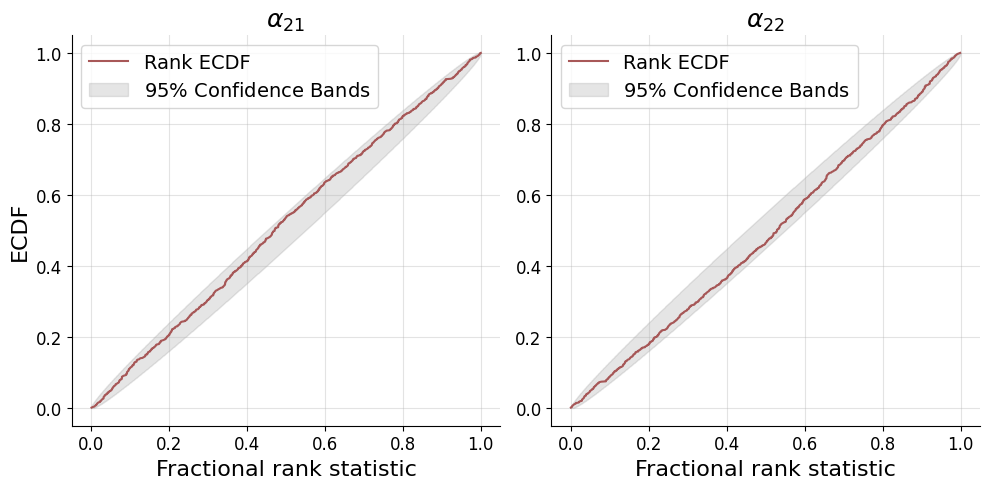

In [22]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_p[:,:,1,:], prior_p[:,1,:], param_names=[r'$\alpha_{21}$', r'$\alpha_{22}$'])

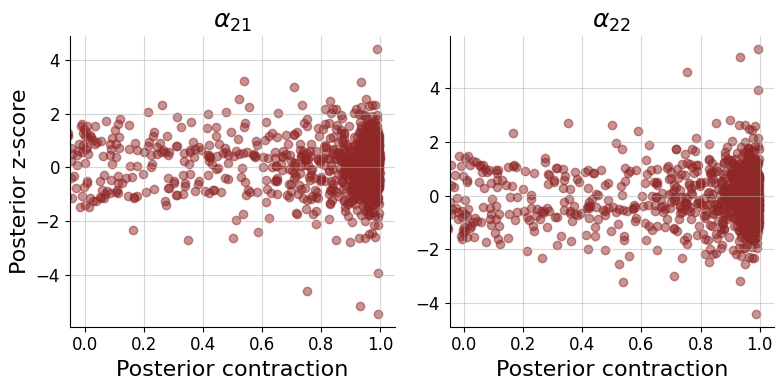

In [23]:
f = bf.diagnostics.plot_z_score_contraction(posterior_p[:,:,1,:], prior_p[:,1,:], param_names=[r'$\alpha_{21}$', r'$\alpha_{22}$'])

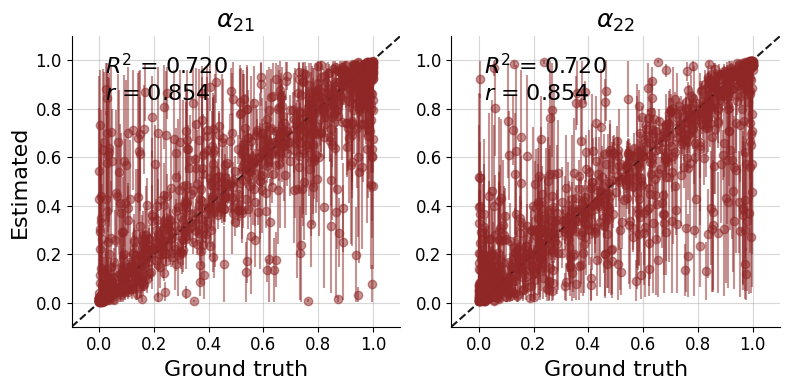

In [24]:
f = bf.diagnostics.plot_recovery(posterior_p[:,:,1,:], prior_p[:,1,:], param_names=[r'$\alpha_{21}$', r'$\alpha_{22}$'])

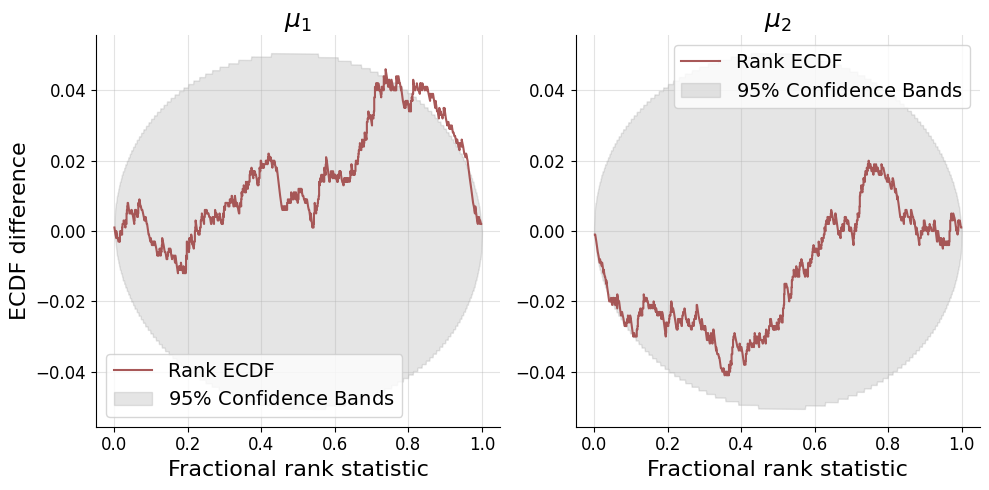

In [25]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_mu, prior_mu, difference=True, param_names=[r'$\mu_{1}$', r'$\mu_{2}$'])

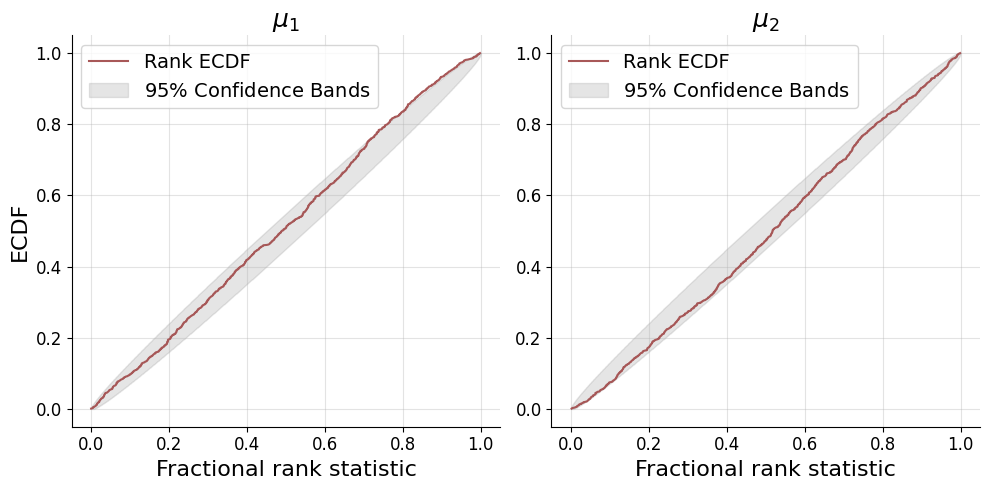

In [26]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_mu, prior_mu, param_names=[r'$\mu_{1}$', r'$\mu_{2}$'])

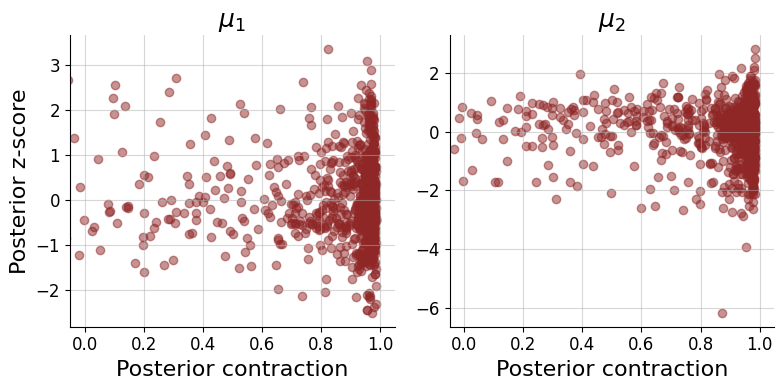

In [27]:
f = bf.diagnostics.plot_z_score_contraction(posterior_mu, prior_mu, param_names=[r'$\mu_{1}$', r'$\mu_{2}$'])

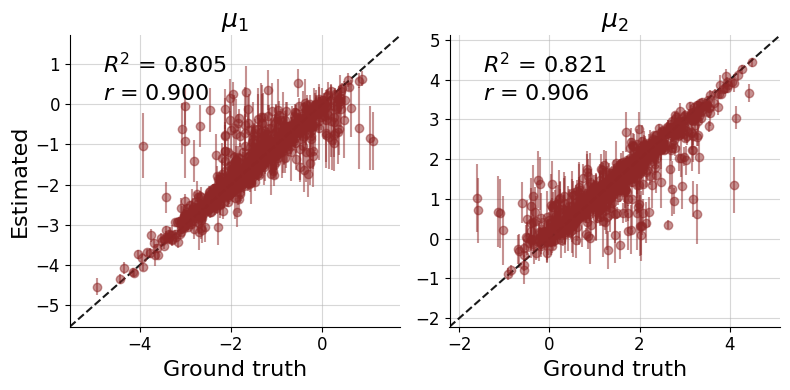

In [28]:
f = bf.diagnostics.plot_recovery(posterior_mu, prior_mu, param_names=[r'$\mu_{1}$', r'$\mu_{2}$'])